In [1]:
import utils
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
import matplotlib.pyplot as plt



The point of this notebook is to try something different. In the real world, you will rarely have a fully labeled dataset, so most problems end up being semi-supervised (and require some unsupervised learning). 

As such, we will assume that only 6 images of each letter class is labeled, and we will use them as the initial points belonging to a cluster of images. There will be k clusters (k=26 for english and k=10 for greek) for each letter class that exists in the dataset. Then we will run K-means and see how the set will cluster the images. It would be cool to see how these images will be grouped together. Our intuition tells us that we will mostly have clusters that resemble the original classes with very some error. However, there is nothing better than empirical results so let's try it.

In [2]:
files = utils.filenames()
root_dir = utils.get_project_root_dir()

X , y = {}, {}

for lang in ['english','greek']:
    X[lang], y[lang] = utils.load_data(f"{root_dir}/{files[lang]['train']}")

    for sett in [ 'val', 'test']:
        X_tmp, y_tmp = utils.load_data(f"{root_dir}/{files[lang][sett]}")
        X[lang] = np.concatenate((X[lang],X_tmp))
        y[lang] = np.concatenate((y[lang],y_tmp))

In [3]:
def find_first_6(y):
    indices = defaultdict(list)
    for idx,label in enumerate(y):

        indices[int(label)].append(idx)
      
        if idx % 100 == 0:
            bigger_than6 = list(map(lambda i: len(i)>=6, indices.values()))
            if all(bigger_than6):
                break
    
    first6 = [indices[key][:6] for key in sorted(indices.keys())]

    return first6


In [4]:
eng_indices = find_first_6(y['english'])
greek_indices = find_first_6(y['greek'])

In [5]:
def plot_6images(imgs):
    fig = plt.figure(figsize=(32/4,32/4))
    # imgs = X[indices]
    for i,img in enumerate(imgs):
        fig.add_subplot(3,3,i+1)
        plt.imshow(img.reshape(32,32))    

In [6]:
def compute_centroid(indices,X):
    '''Generate a centroid from the points provided'''
    imgs = X[indices]
    centroid = np.average(imgs,axis=0)
    return centroid

0 [19, 68, 77, 81, 169, 179]
1 [12, 69, 93, 109, 152, 160]
2 [27, 33, 62, 85, 124, 170]
3 [8, 45, 64, 102, 159, 180]
4 [1, 9, 26, 96, 99, 120]


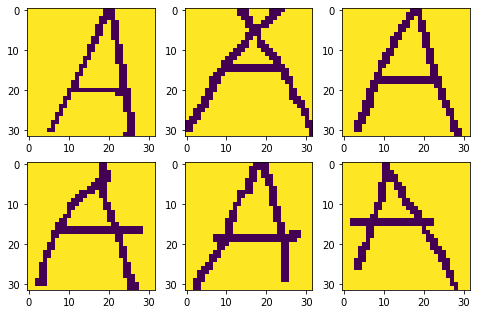

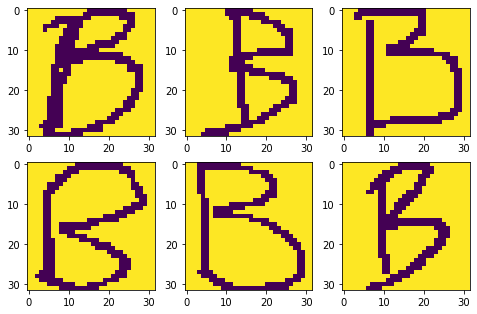

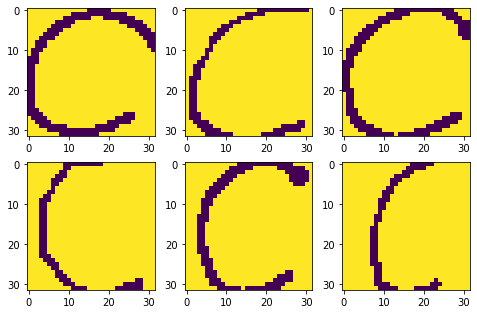

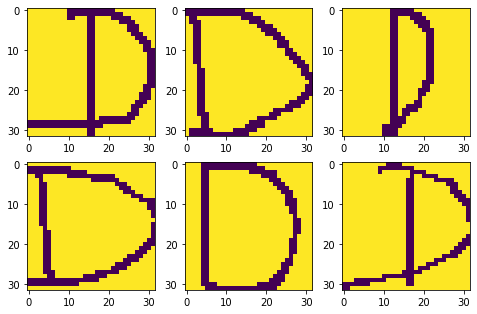

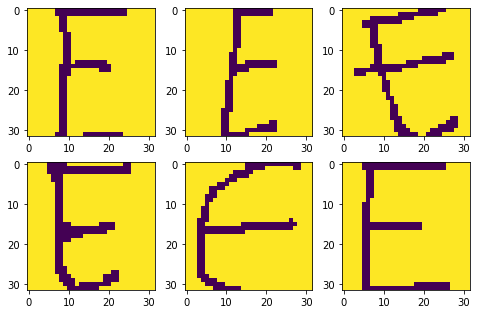

In [7]:
random_letters = list(range(5)) 
for i in random_letters:
    print(i, eng_indices[i])
    plot_6images(X['english'][eng_indices[i]])

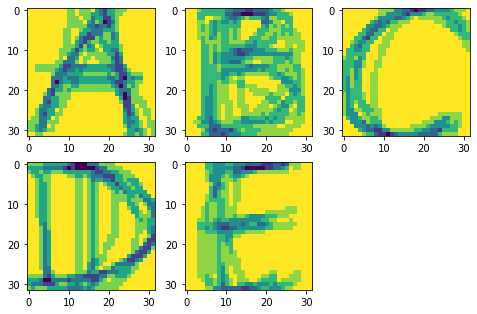

In [8]:
'''Here is what plotting the centroids looks like for each of these letter clusters'''
eng_centroids = [compute_centroid(eng_indices[i],X['english']) for i in random_letters]
plot_6images(eng_centroids)

0 [0, 17, 18, 29, 35, 36]
1 [8, 9, 13, 14, 16, 28]
2 [48, 56, 87, 93, 200, 258]
3 [6, 26, 58, 74, 86, 99]
4 [2, 7, 24, 27, 37, 41]


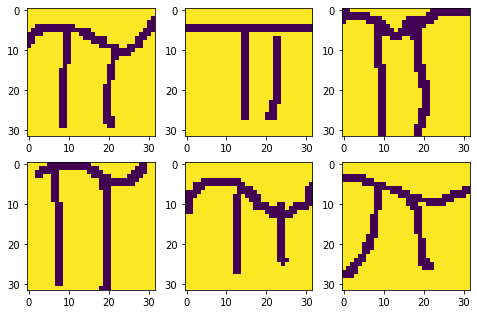

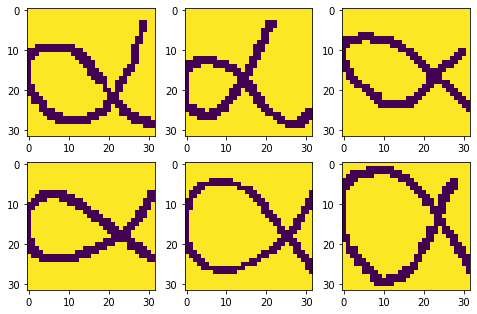

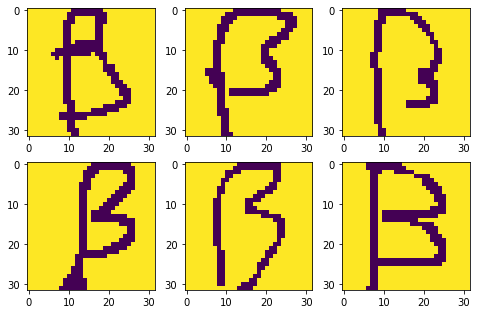

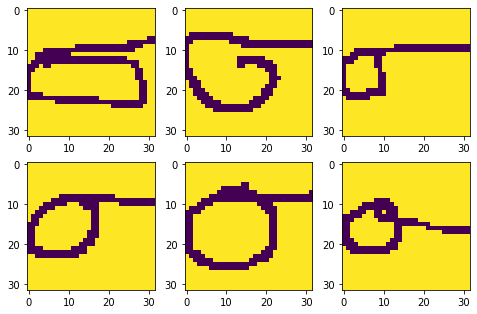

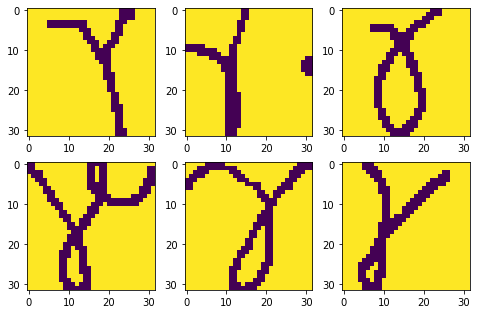

In [9]:
for i in random_letters:
    print(i, greek_indices[i])
    plot_6images(X['greek'][greek_indices[i]])

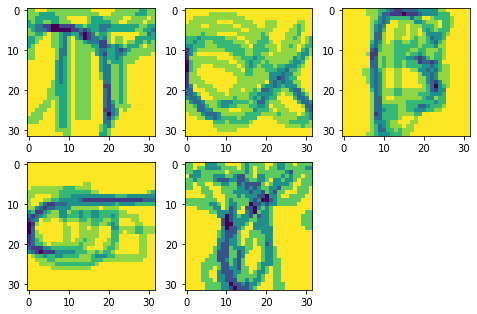

In [10]:
greek_centroids = [compute_centroid(greek_indices[i],X['greek']) for i in random_letters]
plot_6images(greek_centroids)

# Now, let's run some clustering and see what happens!!!

### First version: initialise the centroids by setting the them to distinct letters of the alphabet.
i.e, if we are using the english alphabet, there will be 26 centroids each of them will be a distinct letter. 


In [11]:
def run1(indices,X,):
    centroids = X[[i[0] for i in indices]]
    print(centroids.shape)
    assert centroids.shape == (26,1024 ) or (10,1024), f'centroids are of wrong shape {centroids.shape}'
    clusters = KMeans(n_clusters=centroids.shape[0], init=centroids, verbose=1).fit(X)
    return clusters

In [12]:
eng_clusters = run1(eng_indices, X['english'], )

(26, 1024)
Initialization complete
Iteration 0, inertia 248902.0
Iteration 1, inertia 155055.6933650358
Iteration 2, inertia 150700.1122222267
Iteration 3, inertia 148553.78296372897
Iteration 4, inertia 147335.60453541137
Iteration 5, inertia 146703.92367950676
Iteration 6, inertia 146294.5017301565
Iteration 7, inertia 146073.71076568685
Iteration 8, inertia 145861.02668497007
Iteration 9, inertia 145745.06644760817
Iteration 10, inertia 145640.5371962789
Iteration 11, inertia 145571.04223162847
Iteration 12, inertia 145543.18588535042
Iteration 13, inertia 145508.4837275281
Iteration 14, inertia 145499.87572713583
Converged at iteration 14: strict convergence.


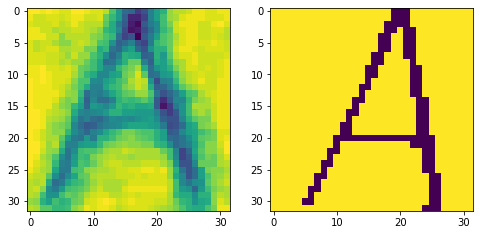

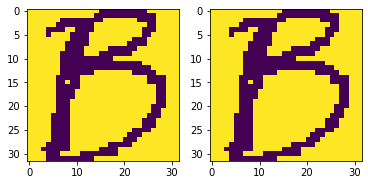

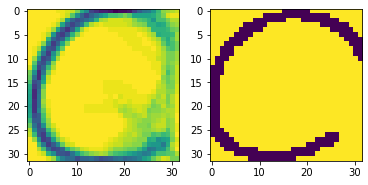

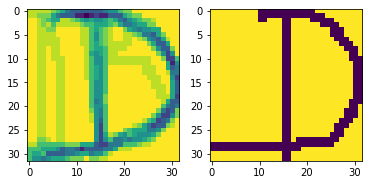

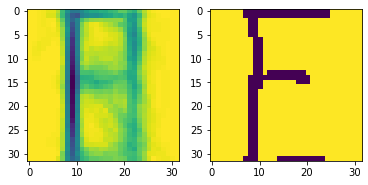

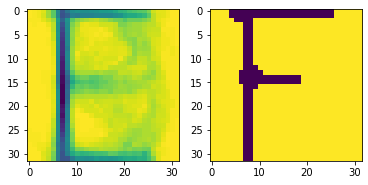

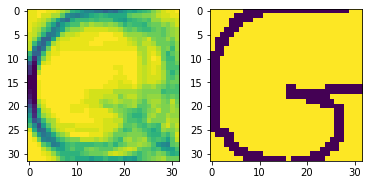

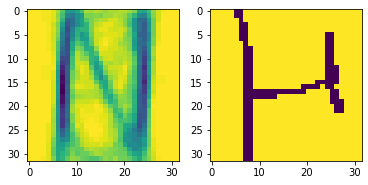

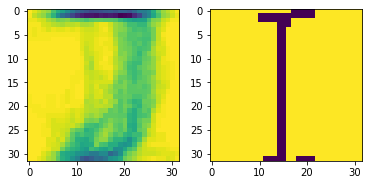

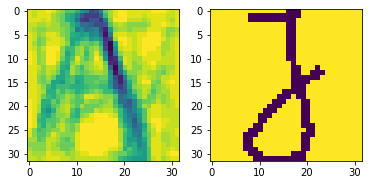

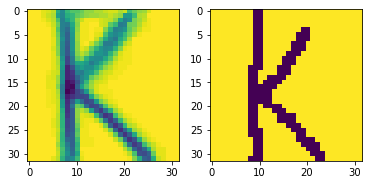

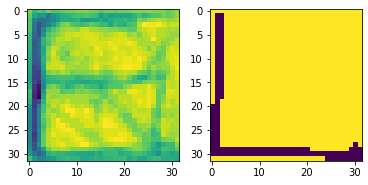

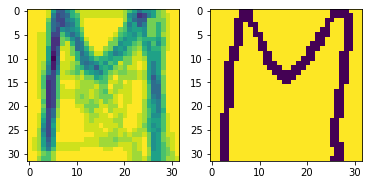

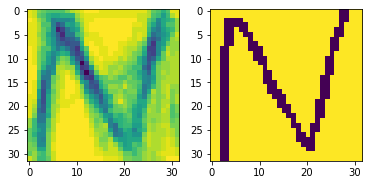

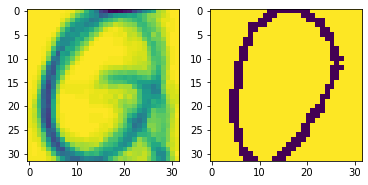

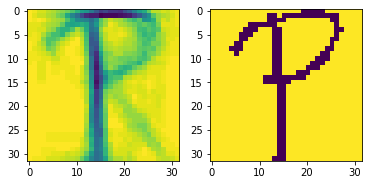

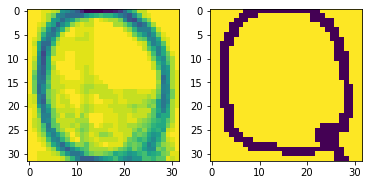

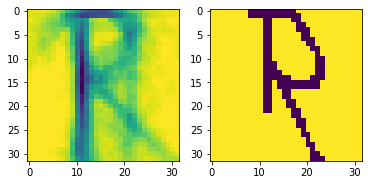

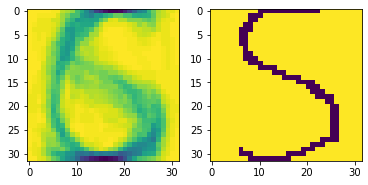

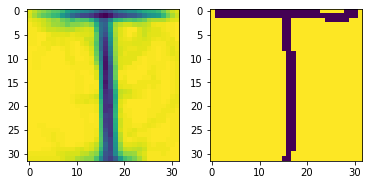

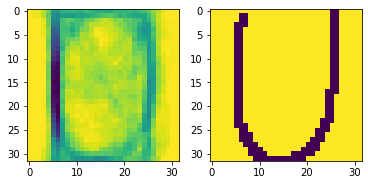

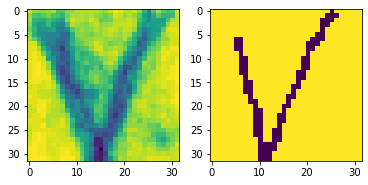

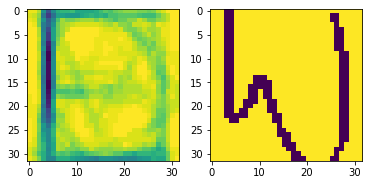

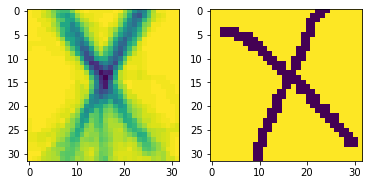

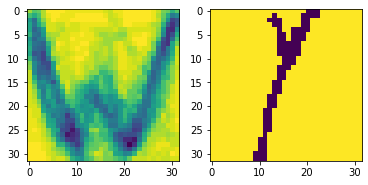

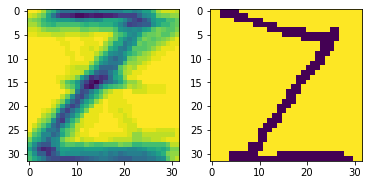

'These are the plotted centroids of after clustering the whole dataset vs the inital centroids'

In [13]:

plt.figure(figsize=(32/4,32/4))
for i,final in enumerate(eng_clusters.cluster_centers_):
    plt.subplot(1,2,1)
    plt.imshow(final.reshape(32,32),)
    plt.subplot(1,2,2)
    initial = X['english'][eng_indices[i][0]]
    plt.imshow(initial.reshape(32,32))
    plt.show()
    
'''These are the plotted centroids of after clustering the whole dataset vs the inital centroids'''

### Let's see how close the clusters are to the original label classes

In [14]:

acc = sklearn.metrics.accuracy_score(y['english'],eng_clusters.labels_)
f1 = sklearn.metrics.f1_score(y['english'],eng_clusters.labels_, average='weighted')
fmt = lambda some_float: float("{:.4f}".format(some_float))

print(f'accuracy: {fmt(acc)}, f1: {fmt(f1)}')

accuracy: 0.3007, f1: 0.2943


In [31]:
def generate_stats(clusters,y_true,letter=0):
    '''for a given letter (value either [0,25] or [A,Z]), generate stats on that cluster'''
    letter = letter.upper() if type(letter)==str else letter
    lang = 'english' if len(clusters.cluster_centers_) == 26 else 'greek'
    index = letter if type(letter)==int else files[lang]['letters'].index(letter)
    # all indices in X of points associated to cluster index 0
    point_indices = np.where(clusters.labels_==index)[0] # because where returns a tuple 

    # get the real class labels of all points that were clustered together    
    real_classes = y_true[point_indices].astype(np.int)
    class_counts = Counter(real_classes)

    def indexToLetter(counterObj):
        dictt = {}
        for k,v in counterObj.items():
            letterKey = files[lang]['letters'][k]
            dictt[letterKey] = v
        
        return {k: v for k,v in sorted(dictt.items(),key=lambda el: el[0])}

    class_counts_letters = indexToLetter(class_counts)


    result = {  'letter': files[lang]['letters'][index],
                'index': index,
                'cluster_size': len(point_indices),
                'count': class_counts_letters,
            }

    return result

In [32]:
def generate_stats_plot(output_of_generate_stats_func):
    '''Self explanatory IMHO'''

    result = output_of_generate_stats_func
    plt.title(f'Cluster composotion of letter {result["letter"]}')
    plt.bar(list(result['count'].keys()), list(result['count'].values()),width=0.9,color='purple')
    plt.xlabel('letters')
    plt.ylabel('occurences in this cluster')
    plt.show()


{'letter': 'A', 'index': 0, 'cluster_size': 63, 'count': {'A': 39, 'G': 5, 'H': 2, 'J': 2, 'M': 3, 'N': 1, 'S': 1, 'T': 1, 'W': 2, 'X': 3, 'Y': 1, 'Z': 3}}


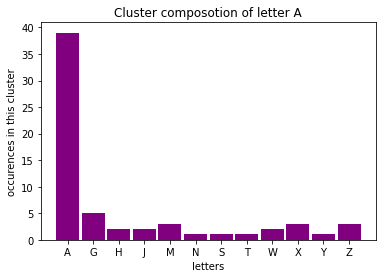


{'letter': 'B', 'index': 1, 'cluster_size': 1, 'count': {'B': 1}}


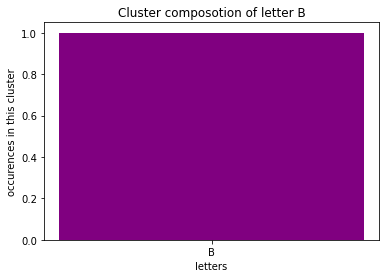


{'letter': 'C', 'index': 2, 'cluster_size': 35, 'count': {'C': 20, 'G': 2, 'O': 7, 'Q': 6}}


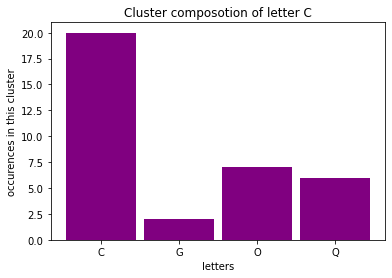


{'letter': 'W', 'index': 22, 'cluster_size': 38, 'count': {'B': 2, 'C': 3, 'D': 3, 'E': 6, 'F': 3, 'L': 10, 'M': 3, 'O': 1, 'P': 1, 'S': 1, 'U': 3, 'W': 2}}


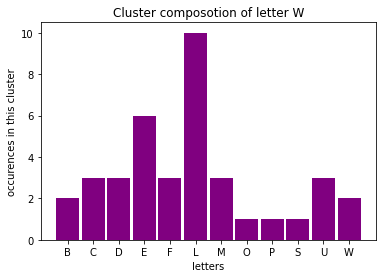


{'letter': 'Y', 'index': 24, 'cluster_size': 60, 'count': {'C': 1, 'G': 1, 'H': 1, 'Q': 3, 'S': 1, 'U': 7, 'V': 4, 'W': 42}}


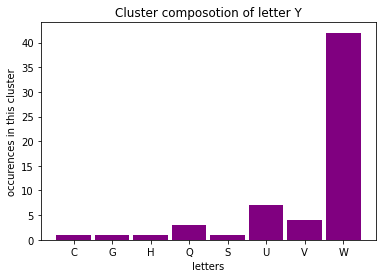


{'letter': 'Z', 'index': 25, 'cluster_size': 41, 'count': {'X': 2, 'Z': 39}}


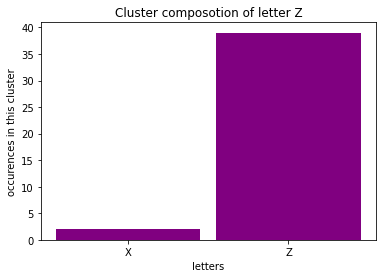

In [33]:
for l in ['A','B','C','W','Y','Z']:
    stats = generate_stats(eng_clusters,y['english'],letter=l)
    print()
    print(stats)
    
    generate_stats_plot(stats)
    

In [34]:
greek_clusters = run1(greek_indices,X['greek'])

(10, 1024)
Initialization complete
Iteration 0, inertia 2046476.0
Iteration 1, inertia 1196326.3559631996
Iteration 2, inertia 1176452.373236909
Iteration 3, inertia 1168272.1750335216
Iteration 4, inertia 1164373.411827707
Iteration 5, inertia 1162852.2281386305
Iteration 6, inertia 1161958.0312575065
Iteration 7, inertia 1161225.3000261036
Iteration 8, inertia 1160459.0527066821
Iteration 9, inertia 1159541.2583199732
Iteration 10, inertia 1158637.1322896874
Iteration 11, inertia 1157701.5974941133
Iteration 12, inertia 1156792.6919012836
Iteration 13, inertia 1156128.982693626
Iteration 14, inertia 1155763.9605018208
Iteration 15, inertia 1155493.8867517293
Iteration 16, inertia 1155295.295095569
Iteration 17, inertia 1155165.1891867593
Iteration 18, inertia 1155075.7946505016
Iteration 19, inertia 1155037.6508063977
Iteration 20, inertia 1155016.056130518
Iteration 21, inertia 1154995.3608545784
Iteration 22, inertia 1154975.0023916343
Iteration 23, inertia 1154957.366982835
Iterat

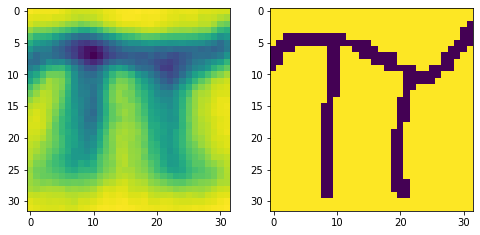

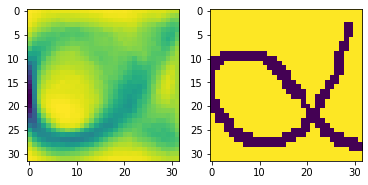

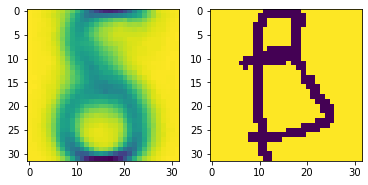

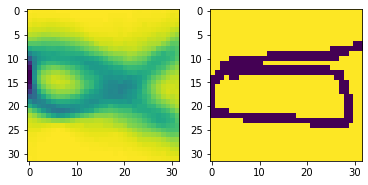

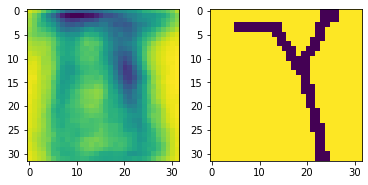

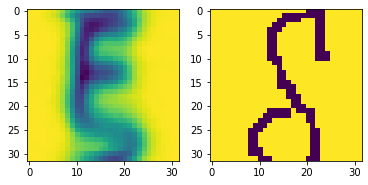

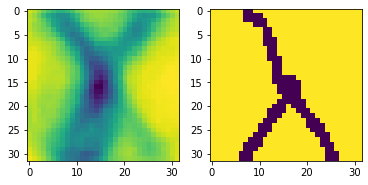

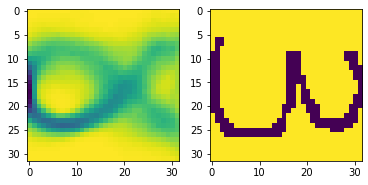

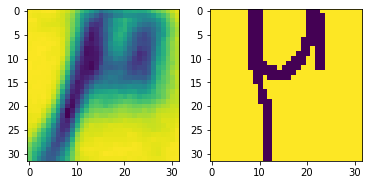

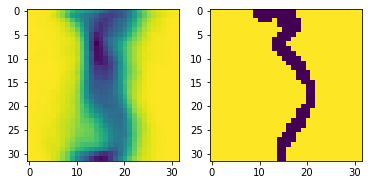

In [35]:
plt.figure(figsize=(32/4,32/4))
for i,final in enumerate(greek_clusters.cluster_centers_):
    plt.subplot(1,2,1)
    plt.imshow(final.reshape(32,32),)
    plt.subplot(1,2,2)
    initial = X['greek'][greek_indices[i][0]]
    plt.imshow(initial.reshape(32,32))
    plt.show()

In [37]:
acc = sklearn.metrics.accuracy_score(y['greek'],greek_clusters.labels_)
f1 = sklearn.metrics.f1_score(y['greek'],greek_clusters.labels_, average='weighted')
fmt = lambda some_float: float("{:.4f}".format(some_float))

print(f'accuracy: {fmt(acc)}, f1: {fmt(f1)}')

accuracy: 0.3369, f1: 0.3827



{'letter': 'π', 'index': 0, 'cluster_size': 916, 'count': {'µ': 121, 'α': 43, 'β': 5, 'γ': 46, 'δ': 1, 'λ': 3, 'ξ': 21, 'π': 648, 'σ': 26, 'ω': 2}}


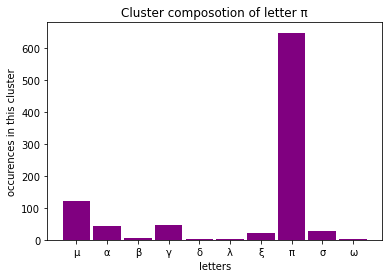


{'letter': 'α', 'index': 1, 'cluster_size': 862, 'count': {'µ': 4, 'α': 623, 'β': 4, 'γ': 5, 'δ': 5, 'ξ': 3, 'π': 1, 'σ': 113, 'ω': 104}}


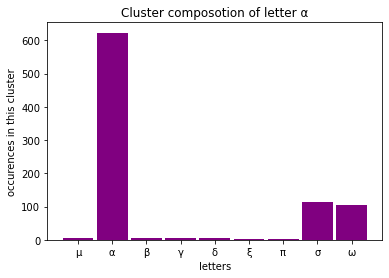


{'letter': 'β', 'index': 2, 'cluster_size': 905, 'count': {'µ': 1, 'β': 9, 'γ': 44, 'δ': 671, 'λ': 2, 'ξ': 171, 'π': 3, 'σ': 3, 'ω': 1}}


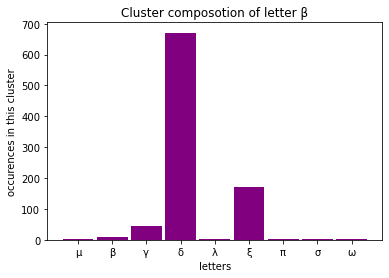


{'letter': 'σ', 'index': 3, 'cluster_size': 1030, 'count': {'µ': 25, 'α': 844, 'β': 1, 'γ': 3, 'δ': 1, 'λ': 2, 'ξ': 4, 'π': 64, 'σ': 37, 'ω': 49}}


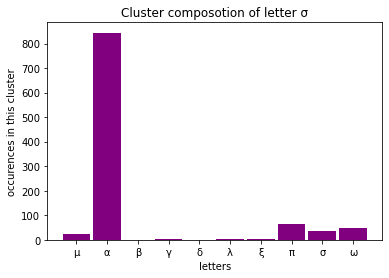


{'letter': 'γ', 'index': 4, 'cluster_size': 956, 'count': {'µ': 66, 'α': 52, 'β': 87, 'γ': 150, 'δ': 83, 'λ': 75, 'ξ': 173, 'π': 246, 'σ': 23, 'ω': 1}}


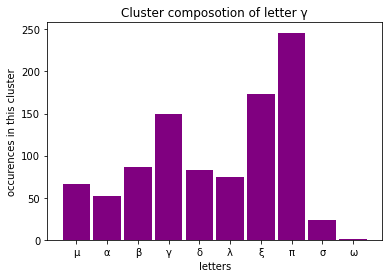

In [36]:
for l in range(5):
    stats = generate_stats(greek_clusters,y['greek'],letter=l)
    print()
    print(stats)
    generate_stats_plot(stats)

## Interpretation:

It is interesting to see how attempting to classify the alphabet without having the image labels is a much harder problem resulting in 30% and 34% for the english and greek alphabet respectively.

That said, you can predict which letters were clustered relatively well by looking above at the plotted final centroids of their clusters next to their respective original centroids.

For some of them, you can clearly tell which letters from the final centroids which letters were supposed to belong in said cluster (for e.g A, and π). For other letters, the distortion is such that you could not tell the original letter of the cluster. Cross reference this with the bar charts showing which letters ended up in which clusters and you can see where the algorithm went wrong. 

What affects which letters get clustered well and which don't. The first and most intuitive hypthesis is that some letters are inherently more unique in their representation, which makes it easier for the algorithm to tell them apart. On the other hand, our datasets aren't perfect and there are some letters that are under-represented in the datasets. Therefore, dragging along with them the problems of class imbalance. You can cross reference the results in this experiment with the [notebook on data exploration](https://github.com/mohanadarafe/comp472-a1/blob/main/data_exploration.ipynb) which takes a look these problems.

Try it yourself below.


{'letter': 'R', 'index': 17, 'cluster_size': 81, 'count': {'A': 3, 'B': 6, 'D': 3, 'E': 1, 'F': 8, 'H': 12, 'K': 1, 'L': 1, 'N': 3, 'P': 8, 'R': 27, 'S': 1, 'T': 3, 'V': 1, 'Y': 3}}


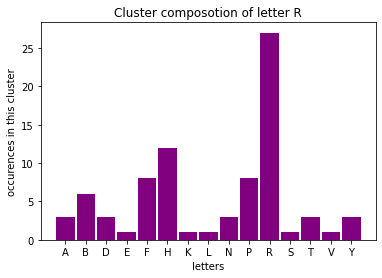

In [39]:
'''Just change the value of the <letter> argument to any english letter of your choice'''
stats = generate_stats(eng_clusters,y['english'],letter="R")
print()
print(stats)
generate_stats_plot(stats)

In [ ]:
'''Just change the value of the <letter> argument to any number between [0-9] of your choice'''
stats = generate_stats(greek_clusters,y['greek'],letter=7)
print()
print(stats)
generate_stats_plot(stats)